<a href="https://colab.research.google.com/github/SumitMangrati/Pytorch-NN-Classification/blob/main/PyTorch_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
#Make 1000 samples
n_samples = 1000

#create circle
x , y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [ ]:
print(f"First 5 samples of x: \n {x[:5]}")
print(f"First 5 samples of y: \n {y[:5]}")

First 5 samples of x: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
 [1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"x1":x[:,0] ,
                        "x2":x[:,1],
                        "label":y })

In [ ]:
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


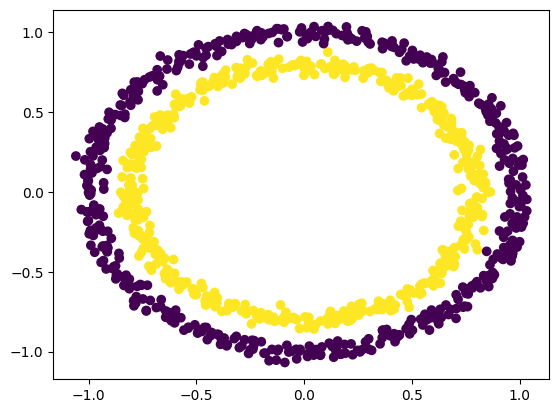

In [ ]:
#Visualize
import matplotlib.pyplot as plt
plt.scatter(x=circles["x1"], y=circles["x2"], c=circles["label"])

###1.1 Check input and output shapes

In [ ]:
x.shape , y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch

In [ ]:
#Turn data into tensors
# Check if x and y are already tensors, if not convert them
if not isinstance(x, torch.Tensor):
  X = torch.from_numpy(x).type(torch.float)
if not isinstance(y, torch.Tensor):
  y = torch.from_numpy(y).type(torch.float)

X[:5] , y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
torch.manual_seed(42)

In [ ]:
#Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

## 2.Build the model

In [ ]:
from torch import nn

#Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Let's create a model class that:

1.Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
2.Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
3.Defines a forward() method containing the forward pass computation of the model.
4.Instantiates the model class and sends it to the target device.

In [ ]:
#1 Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer1 = nn.Linear(in_features=2 , out_features=5)
    self.layer2 = nn.Linear(in_features=5 , out_features=1)

  #3. define a forward() method that outlines the forward pass
  def forward(self , x):
    return self.layer_2(self.layer_1(x)) #x -> layer_1 -> layer_2 -> output

  #4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2 , out_features=5),
    nn.Linear(in_features=5 , out_features=1)
).to(device)
model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Make prediction
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of Predictions: {len(untrained_preds)}")
print(f"Shape of Predictions: {untrained_preds.shape}")
print(f"Length of Test samples: {len(X_test)} , shape of test samples: {X_test.shape}")
print(f"\n First 10 predictions: \n {untrained_preds[:10]}")
print(f"\n First 10 test labels: \n {y_test[:10]}")

Length of Predictions: 200
Shape of Predictions: torch.Size([200, 1])
Length of Test samples: 200 , shape of test samples: torch.Size([200, 2])

 First 10 predictions: 
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

 First 10 test labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss function and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
#Calculate Accuracy
def accuracy_fn(y_true , y_pred):
  correct = torch.eq(y_true , y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3.Training a Model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

the raw outputs of our model are often referred to as logits.

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### 3.2 Building a training and test loop

In [ ]:
torch.manual_seed(42)
epochs = 100

#put data to target device
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

#Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1.Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2.Calculate loss/accuracy
  loss = loss_fn(y_logits , y_train)
  acc = accuracy_fn(y_true=y_train , y_pred=y_pred)

  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4.Loss backward
  loss.backward()

  # 5.Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    #Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #Calculate loss/accuracy
    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy_fn(y_true = y_test , y_pred = test_pred)


    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88% | Test loss: 0.69262, Test acc: 53.00%


## 4.Make predictions and evaluate the model

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


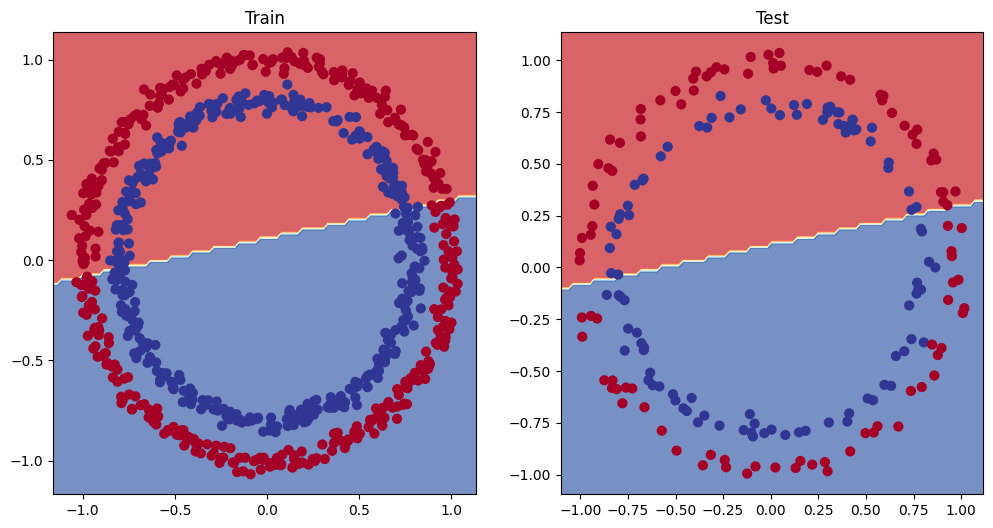

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5.Improving a model(from model perspective)



*   add more layers
*   add more hidden layers
*   Fit for longer
*   Changing the activation fn
*   Changing the learning rate
*   Changing the loss fn



In [ ]:
X_train.shape , y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2 , out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10 , out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10 , out_features = 1)

  def forward(self , x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1



CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Create a loss fn
loss_fn = nn.BCEWithLogitsLoss()
#Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters() , lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  #1.Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits , y_train)
  acc = accuracy_fn(y_true=y_train , y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calculate loss / acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if(epoch % 100 == 0):
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | acc: {acc:.2f} | test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69396 | acc: 50.88 | test_loss: 0.69261 | test_acc: 51.00
Epoch: 100 | Loss: 0.69305 | acc: 50.38 | test_loss: 0.69379 | test_acc: 48.00
Epoch: 200 | Loss: 0.69299 | acc: 51.12 | test_loss: 0.69437 | test_acc: 46.00
Epoch: 300 | Loss: 0.69298 | acc: 51.62 | test_loss: 0.69458 | test_acc: 45.00
Epoch: 400 | Loss: 0.69298 | acc: 51.12 | test_loss: 0.69465 | test_acc: 46.00
Epoch: 500 | Loss: 0.69298 | acc: 51.00 | test_loss: 0.69467 | test_acc: 46.00
Epoch: 600 | Loss: 0.69298 | acc: 51.00 | test_loss: 0.69468 | test_acc: 46.00
Epoch: 700 | Loss: 0.69298 | acc: 51.00 | test_loss: 0.69468 | test_acc: 46.00
Epoch: 800 | Loss: 0.69298 | acc: 51.00 | test_loss: 0.69468 | test_acc: 46.00
Epoch: 900 | Loss: 0.69298 | acc: 51.00 | test_loss: 0.69468 | test_acc: 46.00


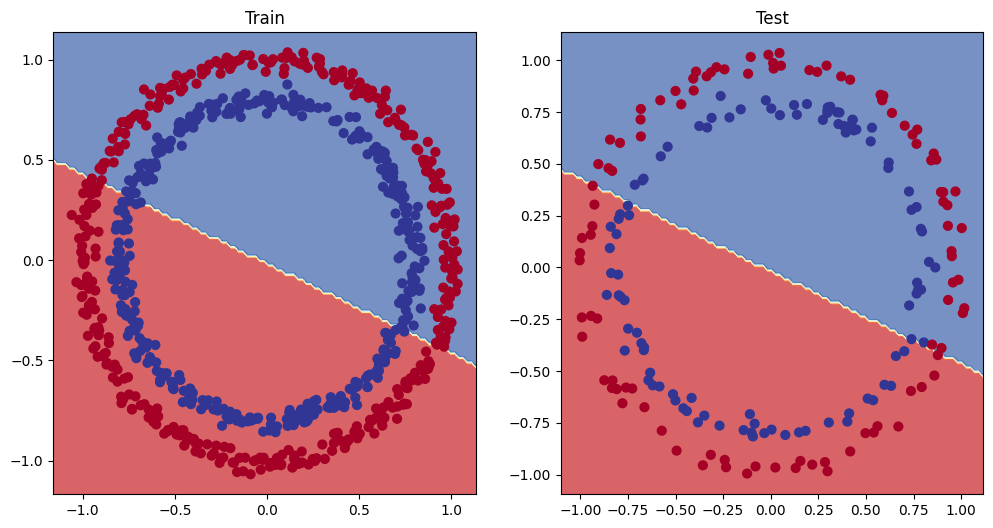

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 preparing data to see if model can fit straight line

In [ ]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#create data
X_regression = torch.arange(start , end , step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

print(len(X_regression))
X_regression[:5] , y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
#create train and test split
train_split = int (0.8 * len(X_regression))
X_train_reg , y_train_reg = X_regression[:train_split] , y_regression[:train_split]
X_test_reg , y_test_reg = X_regression[train_split:] , y_regression[train_split:]

In [ ]:
print(len(X_train_reg))
print(len(y_test_reg))


80
20


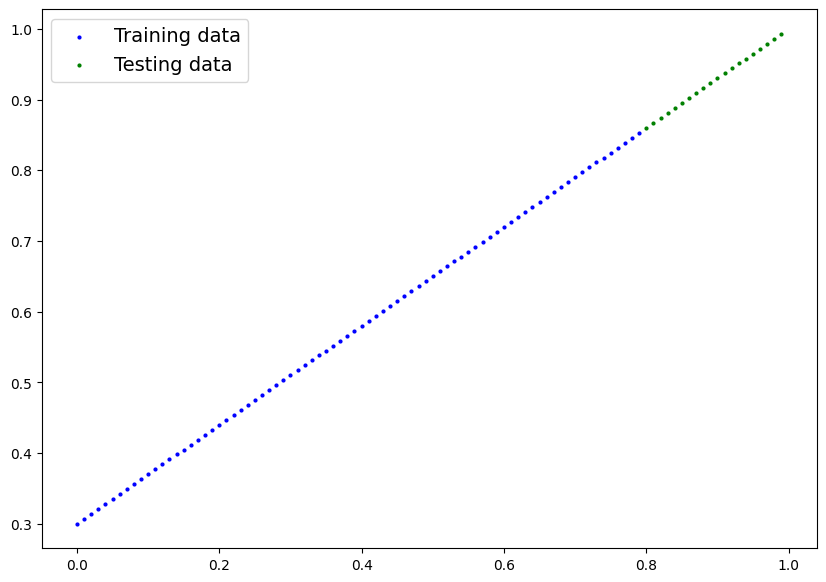

In [ ]:
plot_predictions(train_data=X_train_reg,
    train_labels=y_train_reg,
    test_data=X_test_reg,
    test_labels=y_test_reg
);

### 5.2 Adjust model_1 to fit a straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10 , out_features=10),
    nn.Linear(in_features=10 , out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters() ,
                            lr =  0.01)

In [ ]:
#Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_reg , y_train_reg = X_train_reg.to(device) , y_train_reg.to(device)
X_test_reg , y_test_reg = X_test_reg.to(device) , y_test_reg.to(device)

for epoch in range(epochs):
  model_2.train()

  #1.Forward pass
  y_pred = model_2(X_train_reg)

  #2.Calculate the loss
  loss = loss_fn(y_pred , y_train_reg)

  #3.Optimizer zero grad
  optimizer.zero_grad()

  #4.loss backward
  loss.backward()

  #5.optimizer step
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    #1.Forward pass
    y_pred_test = model_2(X_test_reg)
    #2.calculate the loss
    test_loss = loss_fn(y_pred_test , y_test_reg)

    if(epoch % 100 == 0):
      print(f"epoch: {epoch} | loss: {loss:.5f} | test-loss{test_loss:.5f}")

epoch: 0 | loss: 0.75986 | test-loss0.91103
epoch: 100 | loss: 0.02858 | test-loss0.00081
epoch: 200 | loss: 0.02533 | test-loss0.00209
epoch: 300 | loss: 0.02137 | test-loss0.00305
epoch: 400 | loss: 0.01964 | test-loss0.00341
epoch: 500 | loss: 0.01940 | test-loss0.00387
epoch: 600 | loss: 0.01903 | test-loss0.00379
epoch: 700 | loss: 0.01878 | test-loss0.00381
epoch: 800 | loss: 0.01840 | test-loss0.00329
epoch: 900 | loss: 0.01798 | test-loss0.00360


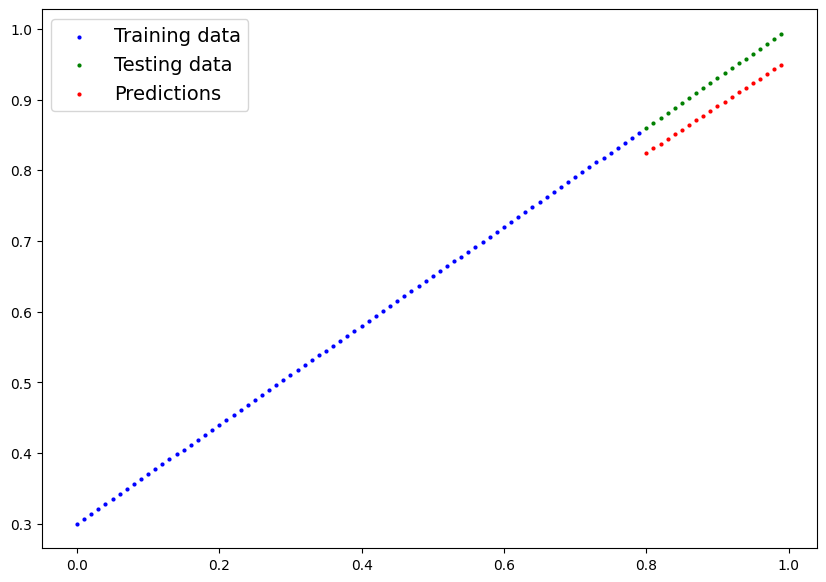

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_reg)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu());

##  6.The missing piece (Non Linearity)

### 6.1 Recreating non Linear data

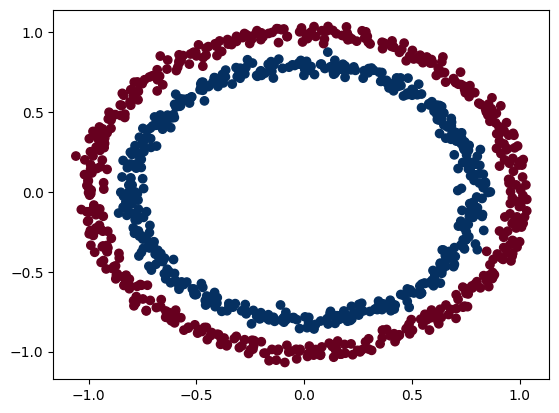

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data
X_train , X_test ,y_train , y_test = train_test_split(X , y ,
                                                      test_size = 0.2,
                                                      random_state = 42)

### 6.2Building a model with non linearity

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2 , out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10 , out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10 , out_features = 1)
    self.relu = nn.ReLU()

  def forward(self , x):
    return self.layer_3(self.relu(self.layer_2(self.relu((self.layer_1(x))))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters() , lr = 0.1)

### 6.3.Training model with nonLinearity

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### 6.4.Evaluating the model

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

y[:10] , y_pred[:10]

(tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]),
 tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]))

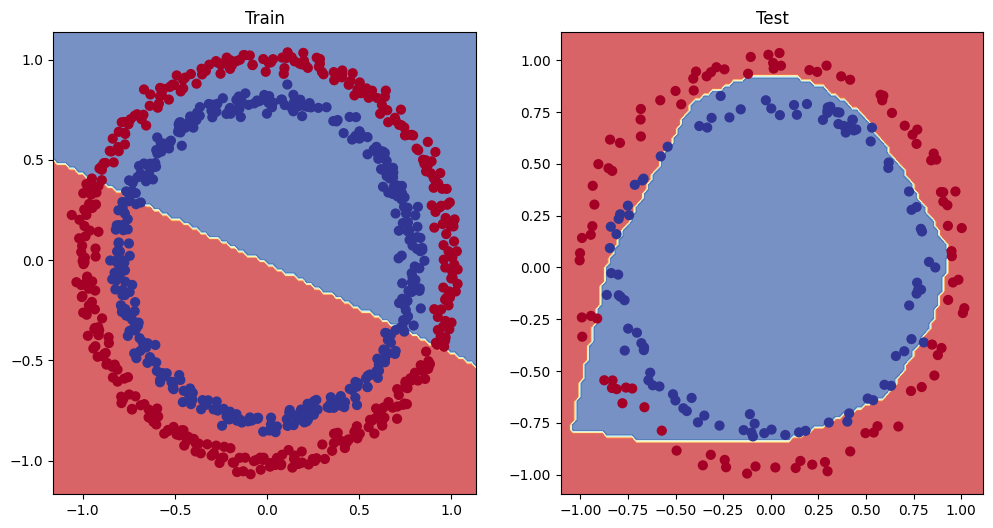

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Multiclass model

### Creating a multiclass dataset

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


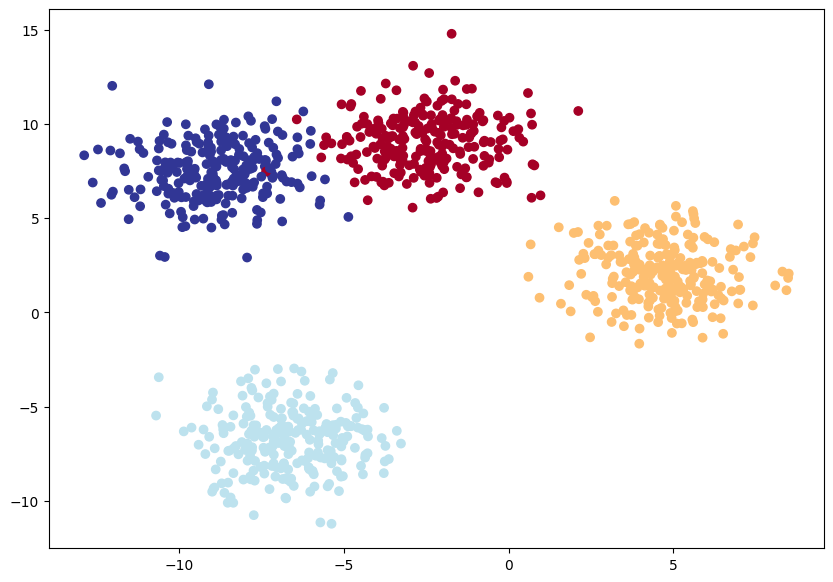

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob , y_blob = make_blobs(n_samples = 1000,
                             n_features = NUM_FEATURES,
                             centers= NUM_CLASSES,
                             cluster_std=1.5,
                             random_state=RANDOM_SEED)
# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5] ,  y_blob[:5])

# 3. Split the data
X_blob_train , X_blob_test , y_blob_train , y_blob_test = train_test_split(X_blob,
                                                                           y_blob,
                                                                           test_size = 0.2,
                                                                           random_state=RANDOM_SEED)
# 4. Plot data
plt.figure(figsize = (10,7))
plt.scatter(X_blob[: , 0] , X_blob[: , 1] , c=y_blob , cmap=plt.cm.RdYlBu);

### building a model

In [ ]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self , input_features , output_features , hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features , out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units , out_features=output_features)
    )

  def forward(self , x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Create loss and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters() ,
                            lr = 0.1)

### Getting prediction probabilities

In [ ]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)

In [ ]:
y_logits = model_4(X_blob_train.to(device))

y_pred_probs = torch.softmax(y_logits , dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], grad_fn=<SliceBackward0>)


In [ ]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3080, 0.3328, 0.1441, 0.2150], grad_fn=<SelectBackward0>)
tensor(1)


### Training and test loop

In [ ]:
torch.manual_seed(42)

epochs = 100

X_blob_train , y_blob_train =  X_blob_train.to(device) , y_blob_train.to(device)
X_blob_test , y_blob_test =  X_blob_test.to(device) , y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  #1.Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits , dim = 1).argmax(dim=1)
  #2.Calculate the loss
  loss = loss_fn(y_logits , y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train , y_pred = y_pred)
  #3.Optimizer zero grad
  optimizer.zero_grad()
  #4.loss backward
  loss.backward()
  #5.optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    #1.Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits , dim = 1).argmax(dim=1)
    #2.calculate the loss
    test_loss = loss_fn(test_logits , y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test , y_pred = test_pred)
    if(epoch % 10 == 0):
      print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f} | test-loss{test_loss:.5f} | test-acc: {test_acc:.2f}")

epoch: 0 | loss: 1.15883 | acc: 40.38 | test-loss1.07554 | test-acc: 48.00
epoch: 10 | loss: 0.64476 | acc: 96.75 | test-loss0.66069 | test-acc: 97.50
epoch: 20 | loss: 0.42535 | acc: 98.50 | test-loss0.43074 | test-acc: 100.00
epoch: 30 | loss: 0.25294 | acc: 99.12 | test-loss0.24508 | test-acc: 99.50
epoch: 40 | loss: 0.11232 | acc: 99.25 | test-loss0.10229 | test-acc: 99.50
epoch: 50 | loss: 0.06627 | acc: 99.25 | test-loss0.05848 | test-acc: 99.50
epoch: 60 | loss: 0.05068 | acc: 99.25 | test-loss0.04293 | test-acc: 99.50
epoch: 70 | loss: 0.04300 | acc: 99.25 | test-loss0.03491 | test-acc: 99.50
epoch: 80 | loss: 0.03836 | acc: 99.25 | test-loss0.02988 | test-acc: 99.50
epoch: 90 | loss: 0.03525 | acc: 99.25 | test-loss0.02663 | test-acc: 99.50


### Evaluating predictions

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred = torch.softmax(y_logits , dim = 1).argmax(dim=1)



In [ ]:
print(f"Predictions: {y_pred[:10]} \nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test , y_pred=y_pred)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]) 
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


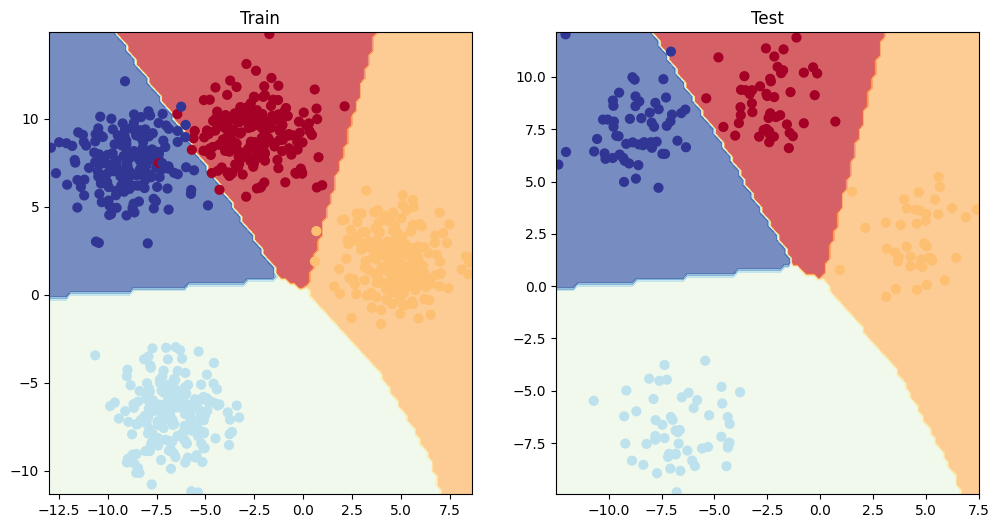

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)